# Univariate time series forecasting without LSTM
This tutorial example presents how to perform forecasts for an univariate time series while using a simple fourrier-form periodic component rather than a LSTM neural network.  

In this example, we use a simple sine-like signal onto which we added a synthetic linear trend.

### Import libraries
Import the various libraries that will be employed in this example.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

### Import from Canari
From Canari, we need to import the several class that will be reused in this example. Notably, we need to import the components that will be used to build the model; In terms of baseline, we use the `LocalTrend` and components. The recurrent pattern is modelled using a `Periodic` component, and the residual is modelled by a `WhiteNoise` compoment.

In [2]:
from canari import (
    DataProcess,
    Model,
    plot_data,
    plot_prediction,
    plot_states,
)
from canari.component import LocalTrend, Periodic, WhiteNoise

### Read data
The raw `.csv` data is saved in a dataframe using the Panda external library.

In [3]:
project_root = Path.cwd().resolve().parents[1]
data_file = str(project_root / "data/toy_time_series/sine.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
# Add a trend to the data
linear_space = np.linspace(0, 2, num=len(df))
df = df.add(linear_space, axis=0)
#
data_file_time = str(project_root / "data/toy_time_series/sine_datetime.csv")
time_index = pd.read_csv(data_file_time, skiprows=1, delimiter=",", header=None)
time_index = pd.to_datetime(time_index[0])
df.index = time_index
df.index.name = "time"
df.columns = ["values"]

### Data preprocess
In terms of pre-processsing, we define here our choice of using the first 80% of the raw time series for trainig and the following 20% for the validaiton set. 

In [4]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    train_split=0.8,
    validation_split=0.2,
    output_col=output_col,
    standardization=False,
)
train_data, validation_data, test_data, standardized_data = data_processor.get_splits()
data_processor.data.head()

,values
time,
2000-01-03 00:00:00,0.000000
2000-01-03 01:00:00,-0.250698
2000-01-03 02:00:00,-0.481395
2000-01-03 03:00:00,-0.682093
2000-01-03 04:00:00,-0.832791


### Define model from components
We instantiatiate each component brom their base class. The `local_trend` baseline component relies on the default hyperparameters. The recurrent `pattern` will use Fourrier-form `Periodic` component. The `residual` is modelled by a Gaussian white noise with a mean 0 and a user-defined standard deviation of 0.1. 

Note that we use `auto_initialize_baseline_states` in order to automatically initialized the baseline hidden states based on the first two years of data.

In [5]:
local_trend = LocalTrend()
pattern = Periodic(mu_states=[0,0],var_states=[1,1],period=24)
residual = WhiteNoise(std_error=0.1)

model = Model(local_trend, pattern, residual)
model.auto_initialize_baseline_states(train_data["y"][0 : 24])

### Filter on train data
We perform recursive SSM 1-step ahead prediction- and update-steps using the Kalman filter over the entire training set.  

In [6]:
mu_train_pred, std_train_pred, states=model.filter(data=train_data)

### Forecast on validation data
We perform recursive 1-step ahead forecasts on the validatiobn set.

In [7]:
mu_val_pred, std_val_pred, states=model.forecast(data=validation_data)

### Predictions and hidden states
We represent the time-series decomposition visually where the raw data is overlaid with the baseline hidden state represented by the _level_. The rate of change of the baseline is caracterised by the _trend_ hidden states. The recurrent pattern is captured by the LSTM neural network. The posterior estimate for the residuals are displayed for the white noise component. The forecast period correspond to the last two years within the validation set depicted by the green-shaded region.

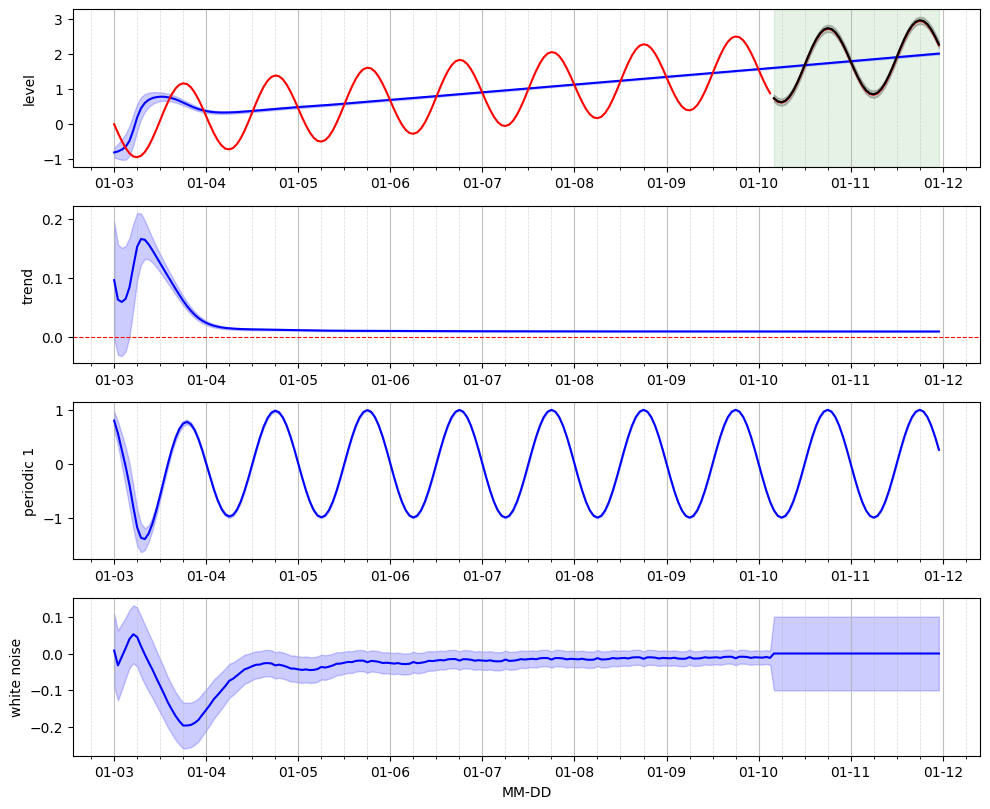

In [8]:
fig, ax = plot_states(
    data_processor=data_processor,
    states=states,
    states_to_plot=["level","trend","periodic 1", "white noise"]
    )
plot_data(
    data_processor=data_processor,
    plot_train_data=True,
    plot_test_data=False,
    plot_validation_data=True,
    sub_plot=ax[0]
    )
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_val_pred,
    std_validation_pred = std_val_pred,
    sub_plot=ax[0],
    color="k",
    )
ax[-1].set_xlabel("MM-DD")
plt.show()